In [ ]:
# pip install matplotlib --user

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import datasets, transforms

torch.set_printoptions(edgeitems=3, linewidth=120)
torch.manual_seed(123)

# 数据集

## 读取数据集并标准化

In [2]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 
               'frog', 'horse', 'ship', 'truck']
data_path = 'data/user/'

cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

len(cifar10), len(cifar2)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

## 不对数据进行标准化

In [4]:
cifar10_unNormalized = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())
cifar2_unNormalized = [(img, label_map[label]) for img, label in cifar10_unNormalized if label in [0, 2]]

len(cifar2_unNormalized)

Files already downloaded and verified


10000

# 查看图片

## 前40张

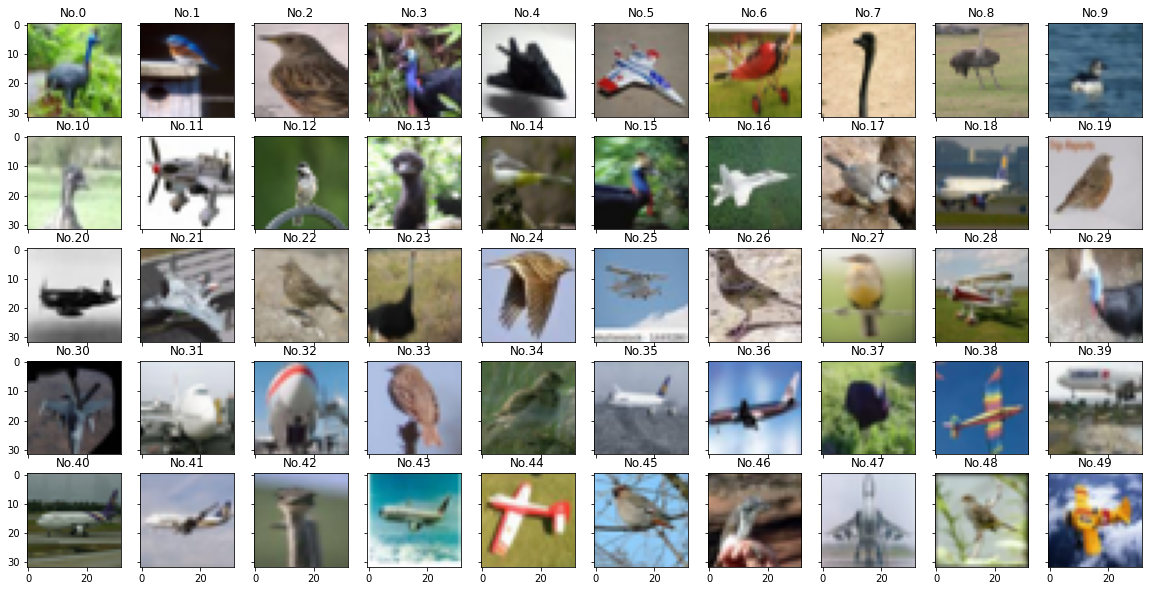

In [24]:
n = 50
n_rows = 5
n_cols = int(n / n_rows)

fig, ax = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(20, 10))
for i in range(n_rows):
    for j in range(n_cols):
        
        No_ = i * 10 + j 
        img, _ = cifar2_unNormalized[No_]
        ax[i][j].imshow(img.permute(1, 2, 0))
        ax[i][j].set_title('No.' + str(No_))
        


## 图片展示函数
- 方便后续使用

In [6]:
def imgs_show(imgs, titles):
    
    n_cols = len(imgs)
    fig, ax = plt.subplots(1, n_cols, figsize=(2.05 * n_cols, 2), 
                           sharex=True, sharey=True)
    ax[0].set_xlim(-0.5, 31.5) 
    ax[0].set_ylim(31.5, -0.5)
    
    for i in range(n_cols):
        
        if len(imgs[i].shape) == 3:
            ax[i].imshow(imgs[i].permute(1, 2, 0))
        else:
            ax[i].imshow(imgs[i], cmap='gray')
        
        ax[i].set_title(titles[i])
        
        if i != 0:
            ax[i].set_xlim(ax[0].get_xlim())
            ax[i].set_ylim(ax[0].get_ylim())
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


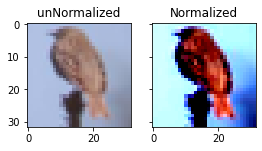

In [7]:
img_33_unNormalized, _ =  cifar2_unNormalized[33]
img_33, _ = cifar2[33]

imgs = [img_33_unNormalized, img_33]
titles = ['unNormalized', 'Normalized']

imgs_show(imgs, titles)

# 卷积

## 创建卷积层

In [8]:
in_channels=3
out_channels=16

conv = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3))
conv, conv.weight.shape, conv.bias.shape


(Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1)),
 torch.Size([16, 3, 3, 3]),
 torch.Size([16]))

In [9]:
img_33_unsqueezed = img_33.unsqueeze(0)
output1 = conv(img_33_unsqueezed)
img_33_unsqueezed.shape, output1.shape


(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


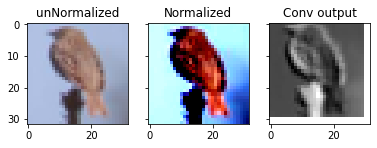

In [10]:
imgs = [img_33_unNormalized, img_33, output1[0, 0].detach()]
titles = ['unNormalized', 'Normalized', 'Conv output']
imgs_show(imgs, titles)


Text(0.5, 1.08, 'Image on Each Channel after Convolution Processing')

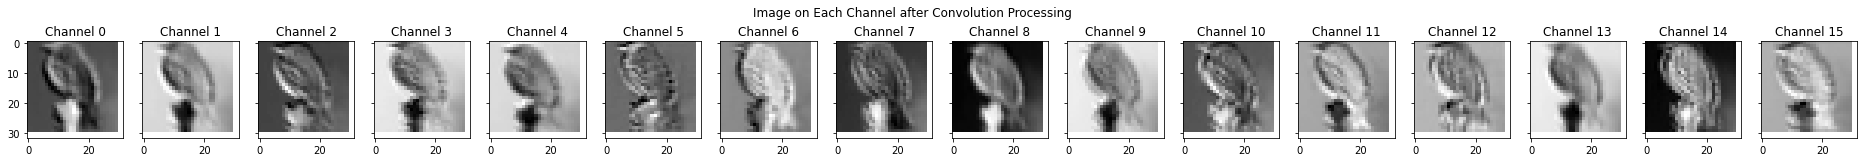

In [11]:
imgs = [output1[0, i].detach() for i in range(out_channels)]
titles = ['Channel ' + str(i) for i in range(out_channels)]
imgs_show(imgs, titles)
plt.suptitle('Image on Each Channel after Convolution Processing', x=0.5, y=1.08)

## 填充边界

In [12]:
in_channels = 3
out_channels = 1

conv = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=1)
output2 = conv(img_33_unsqueezed)
img_33_unsqueezed.shape, output2.shape


(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


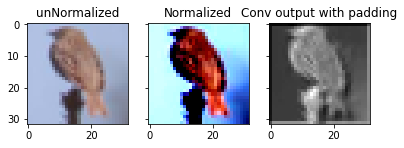

In [13]:
imgs = [img_33_unNormalized, img_33, output2[0, 0].detach()]
titles = ['unNormalized', 'Normalized', 'Conv output with padding']
imgs_show(imgs, titles)


## 检测特征

### 修改权重1

In [14]:
conv = nn.Conv2d(3, 1, kernel_size=(3, 3), padding=1)

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)
    conv.bias.zero_()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


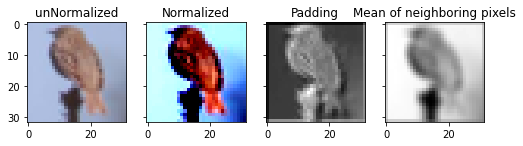

In [15]:
output3 = conv(img_33_unsqueezed)

imgs = [img_33_unNormalized, img_33, output2[0, 0].detach(), output3[0, 0].detach()]
titles = ['unNormalized', 'Normalized', 'Padding', 'Mean of neighboring pixels']
imgs_show(imgs, titles)


### 修改权重2

In [16]:
conv = nn.Conv2d(3, 1, kernel_size=(3, 3), padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


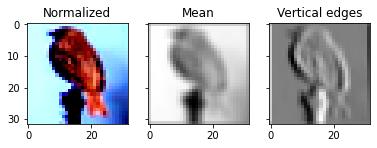

In [17]:
output4 = conv(img_33_unsqueezed)

imgs = [img_33, output3[0, 0].detach(), output4[0, 0].detach()]
titles = ['Normalized', 'Mean', 'Vertical edges']
imgs_show(imgs, titles)


## 池化层

In [18]:
pool = nn.MaxPool2d(kernel_size=(2, 2))
output5 = pool(img_33_unsqueezed)

img_33_unsqueezed.shape, output5.shape


(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

Text(0.5, 1.08, 'Image on Each Channel after MaxPool Processing')

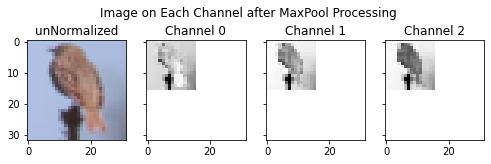

In [19]:
out_channels = 3
imgs = [img_33_unNormalized] + [output5[0, i].detach() for i in range(out_channels)]
titles = ['unNormalized'] + ['Channel ' + str(i) for i in range(out_channels)]
imgs_show(imgs, titles)
plt.suptitle('Image on Each Channel after MaxPool Processing', x=0.5, y=1.08)

# 神经网络

## 编写子模块

In [20]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(3, 3), padding=1)
        self.act1  = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(16, 8, kernel_size=(3, 3), padding=1)
        self.act2  = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        
        self.fc3   = nn.Linear(8 * 8 * 8, 32)
        self.act3  = nn.Tanh()
        
        self.fc4   = nn.Linear(32, 2)
        
    def forward(self, x):
        out1 = self.pool1(self.act1(self.conv1(x)))
        out2 = self.pool2(self.act2(self.conv2(out1)))
        out2 = out2.view(-1, 8 * 8 * 8)
        out3 = self.act3(self.fc3(out2))
        out4 = self.fc4(out3)
        
        return out4

    

In [23]:
model = Net()

for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        print(f'[{name}]')
        for param_name, param_tensor in module.named_parameters():
            print(f'->{param_name}: {param_tensor.numel()} elements')
print('\nTotal number of parameters: ', 
      sum([params.numel() for params in model.parameters()]))



[conv1]
->weight: 432 elements
->bias: 16 elements
[conv2]
->weight: 1152 elements
->bias: 8 elements
[fc3]
->weight: 16384 elements
->bias: 32 elements
[fc4]
->weight: 64 elements
->bias: 2 elements

Total number of parameters:  18090


## 使用没有内部状态的函数式API

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=1)
        self.fc1   = nn.Linear(8 * 8 * 8, 32)
        self.fc2   = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        
        return out
    

In [8]:
model = Net()

for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        print(f'[{name}]')
        for param_name, param_tensor in module.named_parameters():
            print(f'->{param_name}: {param_tensor.numel()} elements')
print('\nTotal number of parameters: ', 
      sum([params.numel() for params in model.parameters()]))


[conv1]
->weight: 432 elements
->bias: 16 elements
[conv2]
->weight: 1152 elements
->bias: 8 elements
[fc1]
->weight: 16384 elements
->bias: 32 elements
[fc2]
->weight: 64 elements
->bias: 2 elements

Total number of parameters:  18090


In [9]:
model(img_33_unsqueezed)

NameError: name 'img_33_unsqueezed' is not defined

## 训练模型

In [12]:
import datetime

current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d  %H:%M:%S.%f")[:-4]
print(formatted_time)


2023-07-24  21:15:12.11


In [60]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        each_epoch_loss = 0.0
        for imgs, labels in train_loader:
            
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            each_epoch_loss += loss.item()
        if epoch in {1, 2, 3} or epoch % 10 == 0:
            current_time = datetime.datetime.now().strftime("%Y-%m-%d  %H:%M:%S.%f")[:-4]
            print(
                f'[Epoch {epoch}] at {current_time} \nTraining loss {each_epoch_loss / len(train_loader):.4f}')
 

In [58]:
n_epochs = 100
batch_size = 64
learning_rate = 1e-2

model = Net()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=batch_size, shuffle=True)

training_loop(
    
    n_epochs,
    optimizer, 
    model,
    loss_fn,
    train_loader
    
)


[Epoch 0] at 2023-07-24  18:48:30.89 
Training loss 0.5940
[Epoch 1] at 2023-07-24  18:48:43.29 
Training loss 0.4933
[Epoch 2] at 2023-07-24  18:48:55.89 
Training loss 0.4697
[Epoch 3] at 2023-07-24  18:49:09.19 
Training loss 0.4448
[Epoch 10] at 2023-07-24  18:50:40.19 
Training loss 0.3285
[Epoch 20] at 2023-07-24  18:52:53.59 
Training loss 0.2917
[Epoch 30] at 2023-07-24  18:55:08.59 
Training loss 0.2693
[Epoch 40] at 2023-07-24  18:57:28.79 
Training loss 0.2486
[Epoch 50] at 2023-07-24  18:59:48.79 
Training loss 0.2269
[Epoch 60] at 2023-07-24  19:02:03.19 
Training loss 0.2098
[Epoch 70] at 2023-07-24  19:04:16.79 
Training loss 0.1967
[Epoch 80] at 2023-07-24  19:06:37.09 
Training loss 0.1825
[Epoch 90] at 2023-07-24  19:08:55.59 
Training loss 0.1694


## 计算模型的精度

In [65]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader   = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def calculate_accuracy(model, data_loader, loader_name='Validation'):
    
    correct = 0
    total   = 0
    
    with torch.no_grad():
        for imgs, labels in data_loader:
            outputs = model(imgs)
            _, preds = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((preds == labels).sum())
    
    print(f'Accuracy of Model on [{loader_name}] set is {correct / total:.4f}')

calculate_accuracy(model, train_loader, 'Train')
calculate_accuracy(model, val_loader)    
    

Accuracy of Model on [Train] set is 0.9093
Accuracy of Model on [Validation] set is 0.8615


## 保存并加载模型

In [80]:
torch.save(model.state_dict(), 'airplanes_vs_birds.pt')  # 只有模型的权重、没有结构

loaded_model = Net()
loaded_model.load_state_dict(torch.load('airplanes_vs_birds.pt'))


<All keys matched successfully>

## 使用GPU

In [13]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f'Training model on deivce [{device}]...')

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        each_epoch_loss = 0.0
        for imgs, labels in train_loader:

            imgs   = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            each_epoch_loss += loss
    
        current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")[: -4]
        if epoch in {1, 2, 3, 4, 5} or epoch % 10 == 0:
            print(f'[Epoch: {epoch}] at {current_time} \nTraining Loss: {each_epoch_loss / len(train_loader):.4f}')

        

n_epochs = 100
batch_size = 64
learning_rate = 1e-2

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=batch_size, shuffle=True)

training_loop(
    
    n_epochs,
    optimizer, 
    model,
    loss_fn,
    train_loader
    
)


Training model on deivce [cuda]...
[Epoch: 1] at 2023-07-24 21:15:19.80 
Training Loss: 0.5838
[Epoch: 2] at 2023-07-24 21:15:20.70 
Training Loss: 0.5027
[Epoch: 3] at 2023-07-24 21:15:21.51 
Training Loss: 0.4837
[Epoch: 4] at 2023-07-24 21:15:22.49 
Training Loss: 0.4707
[Epoch: 5] at 2023-07-24 21:15:23.23 
Training Loss: 0.4541
[Epoch: 10] at 2023-07-24 21:15:26.45 
Training Loss: 0.3513
[Epoch: 20] at 2023-07-24 21:15:34.03 
Training Loss: 0.3031
[Epoch: 30] at 2023-07-24 21:15:41.47 
Training Loss: 0.2803
[Epoch: 40] at 2023-07-24 21:15:49.17 
Training Loss: 0.2532
[Epoch: 50] at 2023-07-24 21:15:56.83 
Training Loss: 0.2329
[Epoch: 60] at 2023-07-24 21:16:04.62 
Training Loss: 0.2162
[Epoch: 70] at 2023-07-24 21:16:11.99 
Training Loss: 0.2007
[Epoch: 80] at 2023-07-24 21:16:19.53 
Training Loss: 0.1865
[Epoch: 90] at 2023-07-24 21:16:27.27 
Training Loss: 0.1746
[Epoch: 100] at 2023-07-24 21:16:34.96 
Training Loss: 0.1602


In [16]:
loaded_model = Net().to(device)
loaded_model.load_state_dict(torch.load('airplanes_vs_birds.pt', map_location=device))


<All keys matched successfully>